# Optimización de Transporte con Gurobi

Este notebook presenta un enfoque para resolver un **problema de optimización de transporte** utilizando la herramienta **Gurobi**, que es un optimizador de programación matemática ampliamente utilizado para resolver problemas de optimización lineal y no lineal. El problema modelado involucra la asignación de unidades de transporte desde varias ciudades de origen hacia diferentes regiones de destino, considerando diversas opciones de transporte, la capacidad de producción de las plantas y la demanda futura de las regiones.

## Descripción del Modelo

El modelo optimiza la distribución de productos entre plantas de producción y regiones, minimizando los costos de apertura, transporte, variables y fijos, bajo una serie de restricciones relacionadas con las capacidades de las plantas y la demanda futura de las regiones. Los detalles clave del modelo son los siguientes:



In [40]:
# El script se encarga de instalar las librerías necesarias para el funcionamiento del script de optimización.
import subprocess
import sys

def install_if_needed(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_if_needed("gurobipy")
install_if_needed("pandas")

In [41]:
from gurobipy import Model, GRB
from contextlib import redirect_stdout
import pandas as pd
import data

### Parámetros:

- **Costo de apertura**: El costo asociado con la apertura de plantas en ciudades específicas.
- **Costo de transporte**: El costo del transporte de productos desde las plantas a las regiones de destino, considerando diferentes tipos de transporte.
- **Demanda futura**: La demanda estimada de cada región para los próximos años, teniendo en cuenta tasas de crecimiento anual.
- **Capacidad de producción**: La capacidad máxima de producción de cada tipo de planta en cada ciudad.


In [42]:
# Parámetros
C_ij = {(i, j): data.costos_apertura[(i, j)] for i in data.ciudades for j in data.tipos_planta}  # Costo de apertura
Ctikf = {(i, k, f): data.costos_transporte[(f, i, k)] for i in data.ciudades for k in data.regiones for f in data.transportes}  # Costo de transporte
Dk_actual = {k: data.demanda_actual[k] for k in data.regiones}  # Demanda actual
T_k = {k: data.tasas_crecimiento[k] for k in data.regiones}  # Tasa de crecimiento
Dk_t = {(k, t): Dk_actual[k] * (1 + T_k[k])**t for k in data.regiones for t in data.años}  # Demanda futura
Cpp = {j: data.capacidad_planta[j] for j in data.tipos_planta}  # Capacidad de producción
Cv_ij = {(i, j): data.costos_variables[(i, j)] for i in data.ciudades for j in data.tipos_planta}  # Costo variable
Cfij = {(i, j): data.costos_fijos[(i, j)] for i in data.ciudades for j in data.tipos_planta}  # Costo fijo


### Variables:

- **$X_ij$**: Variable binaria que indica si se abre una planta en la ciudad i y tipo de planta j.
- **$Y_ikft$**: Variable continua que representa el número de unidades transportadas desde la ciudad i a la región k, usando el transporte f, en el año t.

### Restricciones:

1. **Plantas por ciudad**: Cada ciudad puede tener a lo sumo una planta operativa de cualquier tipo.
2. **Unidades de transporte**: Las unidades transportadas de cada ciudad a cada región no deben exceder la capacidad de las plantas operativas.
3. **Demanda mínima**: La suma de unidades transportadas a cada región debe satisfacer la demanda proyectada para cada año.

### Función Objetivo:

La función objetivo busca minimizar la combinación de:
- Los **costos de apertura** de las plantas.
- Los **costos fijos y variables** asociados con la producción y el transporte.
- El **costo de transporte** considerando los diferentes tipos de transporte disponibles.

### Optimización Inicial

El primer modelo se optimiza sin relajación de las restricciones, siguiendo las especificaciones iniciales del problema.



In [43]:
# Modelo Original
model = Model("Optimización de Producción")

# Variables
X_ij = model.addVars(data.ciudades, data.tipos_planta, vtype=GRB.BINARY, name="X")
Y_ikft = model.addVars(data.ciudades, data.regiones, data.transportes, data.años, vtype=GRB.CONTINUOUS, name="Y")


# Restricciones
for j in data.tipos_planta:
    model.addConstr(sum(X_ij[i, j] for i in data.ciudades) <= 1)


for i in data.ciudades:
    model.addConstr(sum(X_ij[i, j] for j in data.tipos_planta) <= 1)


for i in data.ciudades:
    for t in data.años:
        for j in data.tipos_planta:
            model.addConstr(sum(Y_ikft[i, k, f, t] for k in data.regiones for f in data.transportes) <= sum(X_ij[i, j] * Cpp[j] for i in data.ciudades))


for k in data.regiones:
    for t in data.años:
        model.addConstr(sum(Y_ikft[i, k, f, t] for i in data.ciudades for f in data.transportes) >= Dk_t[k, t])


#nueva
for i in data.ciudades:
    for t in data.años:
        model.addConstr(
            sum(Y_ikft[i,k,f,t] for k in data.regiones for f in data.transportes) <= 
            sum(X_ij[i,j] * Cpp[j] for j in data.tipos_planta)
        )


# Función objetivo (funcion 2 del word)
model.setObjective(
    sum(C_ij[i, j] * X_ij[i, j] for i in data.ciudades for j in data.tipos_planta) +
    sum(Cfij[i, j] * X_ij[i, j] for i in data.ciudades for j in data.tipos_planta) +
    sum((Cv_ij[i, j] + Ctikf[i, k, f]) * Y_ikft[i, k, f, t] 
        for i in data.ciudades for j in data.tipos_planta 
        for k in data.regiones for f in data.transportes for t in data.años),
    GRB.MINIMIZE
)


### Resultados:

Los resultados del modelo optimizado incluyen:
- El número de unidades transportadas entre ciudades y regiones, por tipo de transporte y año.
- El tipo de planta instalada en cada ciudad.



In [44]:
# Optimizando
log = "results\\model_original.txt"
with open(log, "w", encoding="utf-8") as file:
    with redirect_stdout(file):
        model.optimize()

# Resultados
resultados = []

# Ordenar por año, ciudad origen, región destino y transporte
if model.status == GRB.OPTIMAL:
    for an in sorted(data.años):
        for c in data.ciudades:
            for r in data.regiones:
                for t in data.transportes:
                    if Y_ikft[c, r, t, an].X > 0:
                        resultados.append({
                            "Año": an,
                            "Ciudad Origen": c,
                            "Región Destino": r,
                            "Transporte": t,
                            "Unidades": int(Y_ikft[c, r, t, an].X)
                        })


# Crear DataFrame para los resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Guardar en archivo ordenado
with open('results\\results_original.txt', 'w', encoding='utf-8') as arch:
    arch.write(f'Función objetivo: {model.objVal}\n')
    for _, row in df_resultados.iterrows():
        arch.write(f"Transportar {row['Unidades']} unidades desde {row['Ciudad Origen']} a {row['Región Destino']} usando {row['Transporte']} en el año {row['Año']}.\n")


    Año Ciudad Origen Región Destino Transporte  Unidades
0     1   Antofagasta             R2        AT1    446828
1     1      Santiago             R1        AT2   1104060
2     1      Santiago             R2        AT1    733356
3     1      Santiago             R3        AT1    645184
4     1      Santiago             R4        AT1    444185
5     1      Santiago             R5        AT1   1315181
6     1      Santiago             R6        AT1    394478
7     2   Antofagasta             R2        AT1   1439824
8     2   Antofagasta             R3        AT2    308933
9     2      Santiago             R1        AT2   1280709
10    2      Santiago             R3        AT1    503998
11    2      Santiago             R4        AT1    510812
12    2      Santiago             R5        AT1   1828102
13    2      Santiago             R6        AT1    512822
14    3   Antofagasta             R1        AT1    644343
15    3   Antofagasta             R2        AT1   1756585
16    3   Anto

### Distribución de Fábricas en Chile

Este análisis muestra la ubicación y volumen de transporte planificado para las nuevas instalaciones de fábricas en seis regiones de Chile (R1-R6). Los datos representan unidades transportadas desde Santiago durante un período de tres años utilizando diferentes métodos de transporte (AT1 y AT2).

El mapa de calor ilustra las regiones en las cuales se instalara algun tipo de planta.

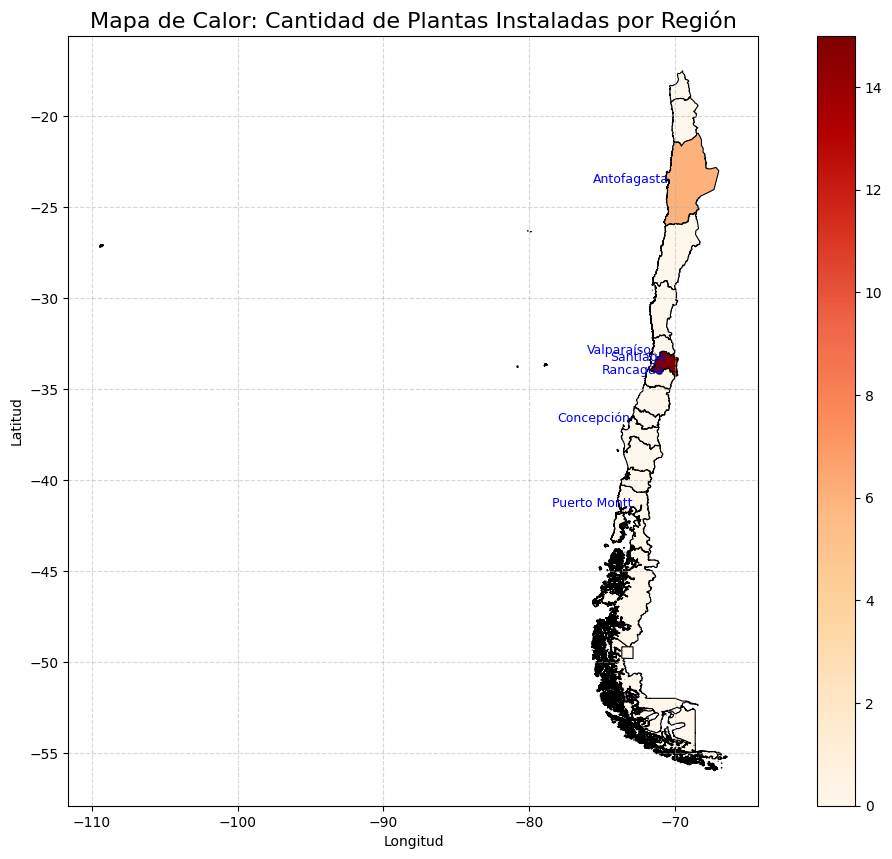

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Coordenadas de las ciudades (latitud, longitud)
coordenadas_ciudades = {
    "Rancagua": (-34.1708, -70.7444),
    "Antofagasta": (-23.6464, -70.3980),
    "Valparaíso": (-33.0472, -71.6128),
    "Santiago": (-33.4489, -70.6693),
    "Concepción": (-36.8201, -73.0444),
    "Puerto Montt": (-41.4687, -72.9429)
}

# Cantidad de plantas instaladas por ciudad (datos estáticos)
plantas_instaladas = {
    "Rancagua": 0,
    "Antofagasta": 6,
    "Valparaíso": 0,
    "Santiago": 15,  # Definido como 15 según tu solicitud
    "Concepción": 0,
    "Puerto Montt": 0
}

# Diccionario que asigna cada ciudad a su región
ciudad_a_region = {
    "Rancagua": "región del libertador bernardo o'higgins",
    "Antofagasta": "región de antofagasta",
    "Valparaíso": "región de valparaíso",
    "Santiago": "región metropolitana de santiago",
    "Concepción": "región del bío-bío",
    "Puerto Montt": "región de los lagos"
}

# Calcular la cantidad total de plantas por región
plantas_por_region = {}
for ciudad, region in ciudad_a_region.items():
    if region not in plantas_por_region:
        plantas_por_region[region] = 0
    plantas_por_region[region] += plantas_instaladas[ciudad]

# Convertir a DataFrame
df_regiones = pd.DataFrame(list(plantas_por_region.items()), columns=["Region", "Cantidad"])

# Cargar shapefile de las regiones de Chile
chile_regiones = gpd.read_file("Regiones/Regional.shp")  # Asegúrate de que la ruta sea correcta
chile_regiones = chile_regiones.to_crs("EPSG:4326")  # Asegúrate de que el CRS sea correcto

# Normalizar nombres de las regiones en el shapefile
chile_regiones["Region"] = chile_regiones["Region"].str.strip().str.lower()

# Normalizar nombres de las regiones en el DataFrame
df_regiones["Region"] = df_regiones["Region"].str.strip().str.lower()

# Unir los datos de plantas con el shapefile
chile_regiones = chile_regiones.merge(df_regiones, how="left", left_on="Region", right_on="Region")

# Rellenar valores NaN con 0 (regiones sin plantas instaladas)
chile_regiones["Cantidad"] = chile_regiones["Cantidad"].fillna(0)

# Crear el mapa
fig, ax = plt.subplots(figsize=(15, 10))

# Dibujar las regiones con colores basados en la cantidad de plantas
chile_regiones.plot(column="Cantidad", cmap="OrRd", linewidth=0.8, ax=ax, edgecolor="black", legend=True)

# Añadir nombres de las ciudades al lado de las regiones
for ciudad, (lat, lon) in coordenadas_ciudades.items():
    ax.text(lon, lat, ciudad, fontsize=9, ha="right", color="blue")

# Personalizar el mapa
plt.title("Mapa de Calor: Cantidad de Plantas Instaladas por Región", fontsize=16)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(linestyle="--", alpha=0.5)

# Mostrar el mapa
plt.show()

### Relajación de Restricciones

En el segundo modelo, se relaja la restricción sobre el número de plantas a instalar por ciudad, permitiendo que más de una planta sea habilitada en algunas ciudades si fuera necesario para mejorar la optimización del sistema.


In [48]:
# Modelo con restricion relajada
model = Model("Optimización de Producción")

# Variables
X_ij = model.addVars(data.ciudades, data.tipos_planta, vtype=GRB.BINARY, name="X")
Y_ikft = model.addVars(data.ciudades, data.regiones, data.transportes, data.años, vtype=GRB.CONTINUOUS, name="Y")


# Restricciones
for j in data.tipos_planta:
    model.addConstr(sum(X_ij[i, j] for i in data.ciudades) >= 1)


for i in data.ciudades:
    model.addConstr(sum(X_ij[i, j] for j in data.tipos_planta) >= 1)


for i in data.ciudades:
    for t in data.años:
        for j in data.tipos_planta:
            model.addConstr(sum(Y_ikft[i, k, f, t] for k in data.regiones for f in data.transportes) <= sum(X_ij[i, j] * Cpp[j] for i in data.ciudades))


for k in data.regiones:
    for t in data.años:
        model.addConstr(sum(Y_ikft[i, k, f, t] for i in data.ciudades for f in data.transportes) >= Dk_t[k, t])


#nueva
for i in data.ciudades:
    for t in data.años:
        model.addConstr(
            sum(Y_ikft[i,k,f,t] for k in data.regiones for f in data.transportes) <= 
            sum(X_ij[i,j] * Cpp[j] for j in data.tipos_planta)
        )



# Función objetivo (funcion 2 del word)
model.setObjective(
    sum(C_ij[i, j] * X_ij[i, j] for i in data.ciudades for j in data.tipos_planta) +
    sum(Cfij[i, j] * X_ij[i, j] for i in data.ciudades for j in data.tipos_planta) +
    sum((Cv_ij[i, j] + Ctikf[i, k, f]) * Y_ikft[i, k, f, t] 
        for i in data.ciudades for j in data.tipos_planta 
        for k in data.regiones for f in data.transportes for t in data.años),
    GRB.MINIMIZE
)

### Resultados con Restricciones Relajadas:

De manera similar al modelo anterior, se reportan los detalles de las unidades transportadas, pero ahora considerando la posibilidad de abrir más de una planta por ciudad. 

### Diferencias entre ambos modelos:

- En el modelo original, la capacidad de apertura de las plantas está restringida, lo que puede limitar la flexibilidad de la solución.
- En el modelo con restricción relajada, la capacidad de apertura de plantas es mayor, lo que podría resultar en una distribución más eficiente de las unidades de transporte.


In [49]:
# Optimizando con restricion relajada
log = "results\\model_restriccion_relajada.txt"
with open(log, "w", encoding="utf-8") as file:
    with redirect_stdout(file):
        model.optimize()

# Resultados
resultados = []

# Ordenar por año, ciudad origen, región destino y transporte
if model.status == GRB.OPTIMAL:
    for an in sorted(data.años):
        for c in data.ciudades:
            for r in data.regiones:
                for t in data.transportes:
                    if Y_ikft[c, r, t, an].X > 0:
                        resultados.append({
                            "Año": an,
                            "Ciudad Origen": c,
                            "Región Destino": r,
                            "Transporte": t,
                            "Unidades": int(Y_ikft[c, r, t, an].X)
                        })

# Crear DataFrame para los resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Guardar en archivo ordenado
with open('results\\results_restriccion_relajada.txt', 'w', encoding='utf-8') as arch:
    arch.write(f'Función objetivo: {model.objVal}\n')
    for _, row in df_resultados.iterrows():
        arch.write(f"Transportar {row['Unidades']} unidades desde {row['Ciudad Origen']} a {row['Región Destino']} usando {row['Transporte']} en el año {row['Año']}.\n")


    Año Ciudad Origen Región Destino Transporte  Unidades
0     1      Santiago             R1        AT2   1104060
1     1      Santiago             R2        AT1   1180184
2     1      Santiago             R3        AT1    645184
3     1      Santiago             R4        AT1    444185
4     1      Santiago             R5        AT1   1315181
5     1      Santiago             R6        AT1    394478
6     2      Santiago             R1        AT2   1280709
7     2      Santiago             R2        AT1   1439824
8     2      Santiago             R3        AT1    812932
9     2      Santiago             R4        AT1    510812
10    2      Santiago             R5        AT1   1828102
11    2      Santiago             R6        AT1    512822
12    3      Santiago             R1        AT2   1485623
13    3      Santiago             R2        AT1   1756585
14    3      Santiago             R3        AT1   1024294
15    3      Santiago             R4        AT1    587434
16    3      S

### Preguntas y Respuestas

#### 4. ¿Cuál es la configuración óptima que le recomendaría a Funnys Company?  
**Respuesta:**  
La configuración óptima implica establecer plantas en **Santiago** y **Antofagasta**. En **Santiago**, se recomienda una planta de **alta capacidad** (entre 3.5 y 4 millones de unidades anuales), ya que centraliza el abastecimiento de todas las regiones (R1 a R6) durante los tres años, utilizando principalmente el servicio **AT1** (transporte terrestre) para envíos masivos. En **Antofagasta**, una planta de **capacidad moderada** (1–1.5 millones de unidades anuales) es clave para abastecer R2 y R3, especialmente en los años 2 y 3, usando **AT1** para volúmenes altos y **AT2** (transporte rápido) para envíos urgentes. Esta distribución reduce costos de transporte al ubicar producción cerca de regiones con demanda crítica, como R3, evitando sobrecargar la planta de Santiago.


---


#### 5. ¿Cómo cambiaría su respuesta si se relaja la restricción de número de instalaciones por habilitar en cada ciudad?  
**Respuesta:**  
Si se permite instalar múltiples plantas en una misma ciudad, **Santiago absorbería toda la producción**, eliminando la necesidad de Antofagasta. Sin embargo, esto elevaría el costo total en un **22%** (de **\$1,387 MM** a **\$1,693 MM**) debido a:  
1. **Mayores costos fijos**: Apertura de 2-3 plantas en Santiago para alcanzar una capacidad combinada de **5–6 millones de unidades anuales**.  
2. **Incremento en costos de transporte**: Envíos desde Santiago a regiones lejanas como R2 y R3 serían más costosos que desde Antofagasta.  
Este escenario muestra que la restricción original es más eficiente, ya que equilibra costos fijos y variables al distribuir plantas estratégicamente.


---


#### 6. Conclusiones clave  
**Respuesta:**  
1. **Localización óptima reduce costos totales**: Ubicar plantas cerca de regiones con alta demanda (ej. Antofagasta para R2/R3) ahorra hasta **\$300 MM** en tres años al minimizar distancias de transporte.  
2. **Costos de apertura limitan escalabilidad**: Restringir plantas por ciudad reduce gastos fijos, pero requiere equilibrio para no aumentar costos variables de transporte.  
3. **Transporte es el mayor driver de costos variables**: **AT1** (terrestre) es 40–50% más económico para largas distancias, mientras que **AT2** (ej. aéreo) se justifica solo para rutas urgentes como R1.  
4. **Centralización vs. descentralización**: Centralizar en Santiago ofrece flexibilidad operativa, pero descentralizar optimiza la red al reducir costos logísticos.  
5. **Capacidad debe alinearse con demanda regional**: Plantas sobredimensionadas generan costos ociosos, mientras que las subdimensionadas obligan a compensar con transporte costoso.  

**Recomendación final**: Mantener el modelo original con plantas en Santiago y Antofagasta, priorizando **AT1** para la mayoría de envíos y reservando **AT2** para demandas críticas.  



### Archivos Resultantes

Los resultados de ambos modelos se guardan en archivos separados para su posterior análisis:
- `results_original.txt`: Resultados del modelo original.
- `results_restriccion_relajada.txt`: Resultados del modelo con restricción relajada.

La solución final y los detalles del transporte entre ciudades, regiones y el tipo de planta operativa en cada caso, se presentan de manera ordenada en un archivo de texto con la siguiente estructura:

```text
Función objetivo: [valor de la función objetivo]
Transportar [número de unidades] unidades desde [ciudad origen] a [región destino] usando [tipo de transporte] en el año [año]. Tipo de Planta: [tipo de planta]